# 第４章 顧客の行動を予測する１０本ノック

## ノック３１

- データを読み込む
  - use_log.csv
  - customer_join.csv

In [1]:
import pandas as pd

In [2]:
uselog = pd.read_csv('../materials/part_04/use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
customer = pd.read_csv('../materials/part_04/customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

## ノック３２

- クラスタリングで顧客をグループ化する

In [5]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head(10)

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47
5,3.750000,3.5,5,2,47
6,3.916667,3.5,7,2,47
7,4.500000,4.0,9,2,47
8,4.083333,3.5,7,2,47
9,4.666667,4.5,7,3,47


In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [7]:
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

In [9]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique())
customer_clustering.head(10)

[3 1 0 2]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3
5,3.750000,3.5,5,2,47,3
6,3.916667,3.5,7,2,47,3
7,4.500000,4.0,9,2,47,3
8,4.083333,3.5,7,2,47,3
9,4.666667,4.5,7,3,47,3


## ノック３３

- クラスタリング結果を分析する

In [10]:
# データ件数の確認
len(customer_clustering)

4192

In [11]:
customer_clustering.columns = ['月内平均値', '月内中央値', '月内最大値', '月内最小値', '会員期間', 'cluster']
customer_clustering.groupby('cluster').count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,1334,1334,1334,1334,1334
1,763,763,763,763,763
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [12]:
customer_clustering.groupby('cluster').mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,3.054713,2.888598,4.756225,1.653997,9.263434
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


## ノック３４

- クラスタリング結果を可視化する
- 複数の変数を可視化する手法
  - ５つの変数を二次元上にプロットする
  - **次元削減** が必要
  - 次元削減は教師なし学習の一種：「情報をなるべく失わないように変数を削減して新しい軸を作り出す」
  - 次元削減の代表的な手法：**PCA（主成分分析）**

In [13]:
from sklearn.decomposition import PCA

In [14]:
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

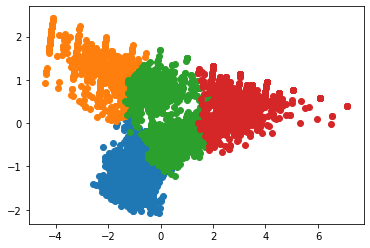

In [16]:
for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster'] == i]
    plt.scatter(tmp[0], tmp[1])

## ノック３５

- クラスタリング結果をもとに退会顧客の傾向を把握する

In [17]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,1,763
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [18]:
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,228
1,0,1,1106
2,1,0,497
3,1,1,266
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


## ノック３６

- 翌月の利用回数予測を行うための準備をする

In [19]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['年月'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['年月', 'customer_id'], as_index=False).count()
uselog_months.rename(columns={'log_id': 'count'}, inplace=True)
del uselog_months['usedate']
uselog_months.head(10)

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
5,201804,AS015746,4
6,201804,AS019860,6
7,201804,AS024181,4
8,201804,AS030404,1
9,201804,AS031206,4


In [26]:
year_months = list(uselog_months['年月'].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months['年月'] == year_months[i]]
    tmp.rename(columns={'count': 'count_pred'}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months['年月'] == year_months[i-j]]
        del tmp_before['年月']
        tmp_before.rename(columns={'count': 'count_{}'.format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head(10)

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
5,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
6,201810,AS019120,3,5.0,8.0,NaN,NaN,NaN,NaN
7,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0
8,201810,AS024181,5,6.0,8.0,3.0,4.0,6.0,4.0
9,201810,AS025956,4,5.0,7.0,7.0,6.0,6.0,NaN


In [27]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head(10)

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0
5,201810,AS024181,5,6.0,8.0,3.0,4.0,6.0,4.0
6,201810,AS031206,5,6.0,6.0,7.0,5.0,6.0,4.0
7,201810,AS036678,6,4.0,6.0,5.0,8.0,6.0,7.0
8,201810,AS038564,5,5.0,2.0,2.0,4.0,5.0,6.0
9,201810,AS040841,4,6.0,5.0,5.0,4.0,6.0,8.0


## ノック３７

- 特徴となる変数を付与する

In [28]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on='customer_id', how='left')
predict_data.head(10)

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01
5,201810,AS024181,5,6.0,8.0,3.0,4.0,6.0,4.0,2016-10-01
6,201810,AS031206,5,6.0,6.0,7.0,5.0,6.0,4.0,2016-12-01
7,201810,AS036678,6,4.0,6.0,5.0,8.0,6.0,7.0,2016-05-01
8,201810,AS038564,5,5.0,2.0,2.0,4.0,5.0,6.0,2015-10-01
9,201810,AS040841,4,6.0,5.0,5.0,4.0,6.0,8.0,2017-05-01


In [29]:
from dateutil.relativedelta import relativedelta

In [31]:
predict_data['now_date'] = pd.to_datetime(predict_data['年月'], format='%Y%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])

predict_data['period'] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
    predict_data['period'][i] = 12 * delta.years + delta.months

predict_data.head(10)

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12
5,201810,AS024181,5,6.0,8.0,3.0,4.0,6.0,4.0,2016-10-01,2018-10-01,24
6,201810,AS031206,5,6.0,6.0,7.0,5.0,6.0,4.0,2016-12-01,2018-10-01,22
7,201810,AS036678,6,4.0,6.0,5.0,8.0,6.0,7.0,2016-05-01,2018-10-01,29
8,201810,AS038564,5,5.0,2.0,2.0,4.0,5.0,6.0,2015-10-01,2018-10-01,36
9,201810,AS040841,4,6.0,5.0,5.0,4.0,6.0,8.0,2017-05-01,2018-10-01,17


## ノック３８

- 来月の利用回数予測モデルを作成する

In [33]:
from sklearn import linear_model, model_selection

In [34]:
predict_data = predict_data.loc[predict_data['start_date'] >= pd.to_datetime('20180401')]

In [38]:
model = linear_model.LinearRegression()

X = predict_data[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period']]
y = predict_data['count_pred']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
model.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6013867644350335
0.6252435063643293


## ノック３９

- モデルに寄与している変数を確認する

In [40]:
coef = pd.DataFrame({'feature_names': X.columns, 'coefficient': model.coef_})
coef

,feature_names,coefficient
0,count_0,0.330107
1,count_1,0.186934
2,count_2,0.162048
3,count_3,0.185994
4,count_4,0.098789
5,count_5,0.060153
6,period,0.103919


## ノック４０

- 来月の利用回数を予測する

In [41]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [42]:
model.predict(x_pred)

array([3.91570731, 2.03639328])

In [43]:
uselog_months.to_csv('use_log_months.csv', index=False)